<a href="https://colab.research.google.com/github/7201krap/PYTORCH_introduction_to_pytorch/blob/main/MNIST_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

mnist_testset  = datasets.MNIST(root='./data', 
                                train=False, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

train_dataloader = torch.utils.data.DataLoader(mnist_trainset, 
                                               batch_size=50, 
                                               shuffle=True)

test_dataloader  = torch.utils.data.DataLoader(mnist_testset, 
                                               batch_size=50, 
                                               shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ",  len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


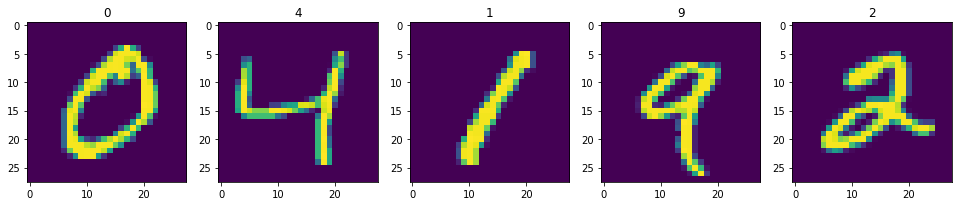

In [3]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

In [4]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = torch.nn.Linear(784, 256)
        self.linear_2 = torch.nn.Linear(256, 10)
        self.sigmoid  = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid(x)
        pred = self.linear_2(x)

        return pred

In [8]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()

# # adagrad 
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)

# adadelta 
optimizer = torch.optim.Adadelta(model.parameters(), lr=1)

# # SGD
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [9]:
no_epochs = 20
train_loss = list()
test_loss  = list()
test_acc   = list()
best_test_loss = 1

In [11]:
for epoch in range(no_epochs):
    total_train_loss = 0
    total_test_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # testing 
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(test_dataloader):

        pred = model(image)

        loss = criterion(pred, label)
        total_test_loss += loss.item()

        # we now need softmax because we are testing.
        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_testset)
    test_acc.append(accuracy)

    total_test_loss = total_test_loss / (itr + 1)
    test_loss.append(total_test_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Test Loss: {:.8f}, Test Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_test_loss, accuracy))

    if total_test_loss < best_test_loss:
        best_test_loss = total_test_loss
        print("Saving the model state dictionary for Epoch: {} with Test loss: {:.8f}".format(epoch + 1, total_test_loss))
        torch.save(model.state_dict(), "model.dth")

torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([50, 10])
torch.Size([50])
torch.Size([

KeyboardInterrupt: ignored

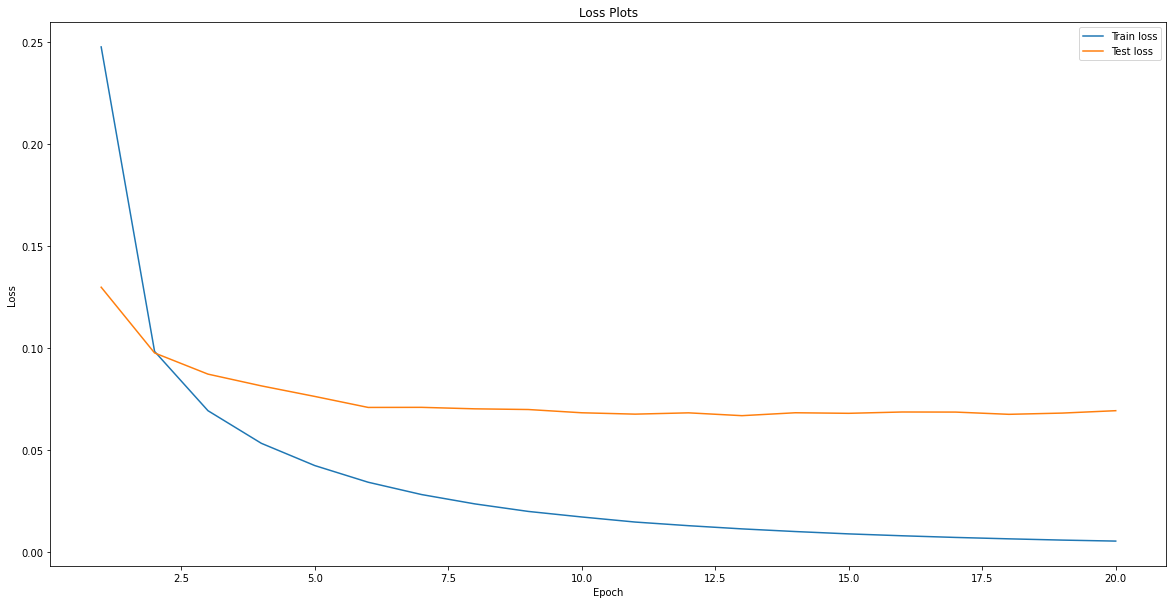

In [8]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), test_loss,  label="Test loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='best')
plt.show()

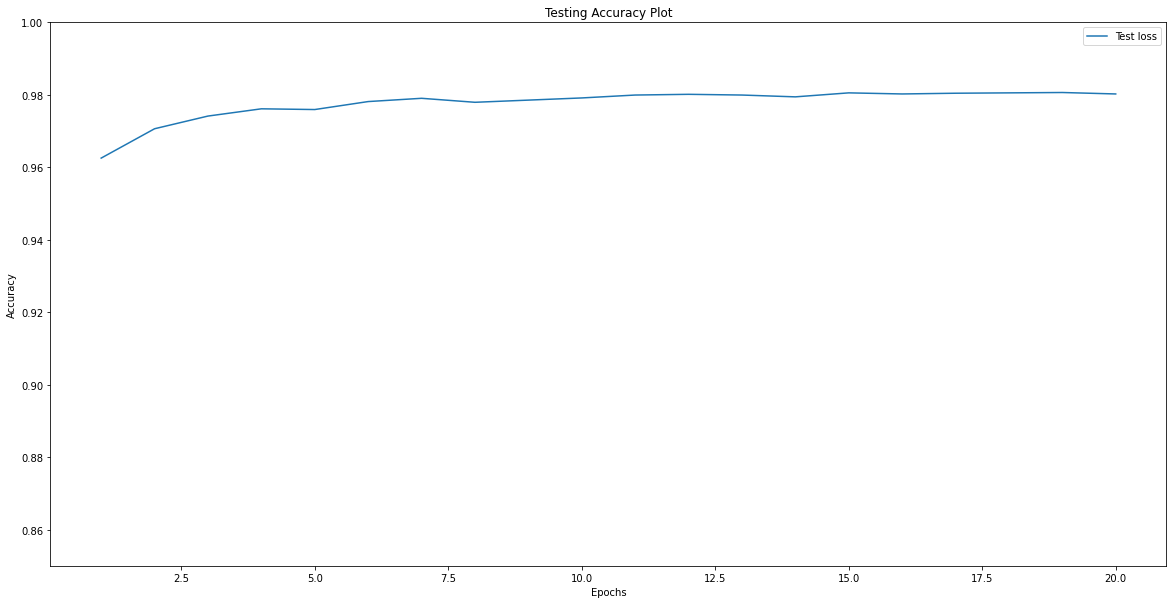

In [16]:
fig = plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), test_acc,  label="Test loss")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.85, 1)
plt.title("Testing Accuracy Plot")
plt.legend(loc='best')
plt.show()